<a href="https://colab.research.google.com/github/LAKSHAYRATRA/Covid_Trend_Prediction_ML_Project/blob/main/Final_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
!pip install prophet
from prophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [ ]:
covid=pd.read_csv("/content/covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.000000,0.000000,0.000000
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.000000,0.000000,0.000000
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.000000,0.000000,0.000000


In [ ]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (98252, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     31156
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [ ]:
# Dropping column "SNo" as it is not useful
covid.drop(["SNo"], axis=1, inplace=True)

In [ ]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [ ]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [ ]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [ ]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  24996456.0
Total number of Recovered Cases around the World:  16409757.0
Total number of Deaths Cases around the World:  842499.0
Total number of Active Cases around the World:  7744200.0
Total number of Closed Cases around the World:  17252256.0
Approximate number of Confirmed Cases per Day around the World:  113106.0
Approximate number of Recovered Cases per Day around the World:  74252.0
Approximate number of Death Cases per Day around the World:  3812.0
Approximate number of Confirmed Cases per hour around the World:  4713.0
Approximate number of Recovered Cases per hour around the World:  3094.0
Approximate number of Death Cases per hour around the World:  159.0
Number of Confirmed Cases in last 24 hours:  262008.0
Number of Recovered Cases in last 24 hours:  211592.0
Number of Death Cases in last 24 hours:  5375.0


In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [ ]:
country_last_24_confirmed=[]
country_last_24_recovered=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])

In [ ]:
Last_24_Hours_country=pd.DataFrame(list(zip(countrywise.index,country_last_24_confirmed,country_last_24_recovered,country_last_24_deaths)),
                                   columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])

Text(0.5, 1.0, 'Top 15 Countries with Highest Number of Death Cases in Last 24 Hours')

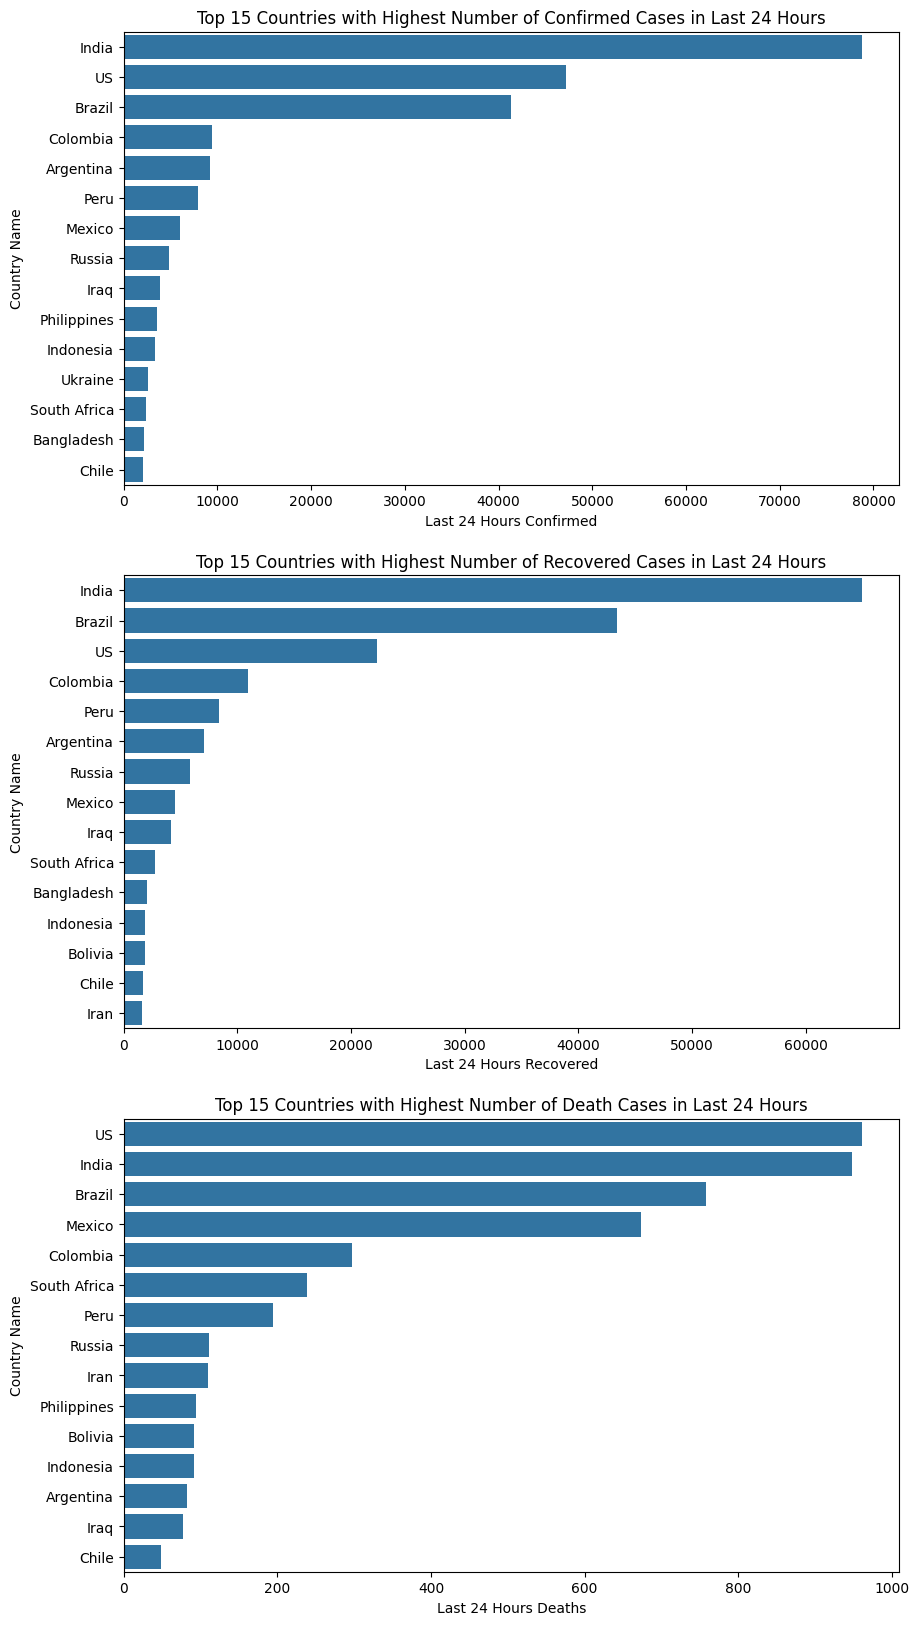

In [ ]:
Top_15_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(15)
Top_15_Recoverd_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(15)
Top_15_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(15)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_15_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_15_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 Countries with Highest Number of Confirmed Cases in Last 24 Hours")
sns.barplot(x=Top_15_Recoverd_24hr["Last 24 Hours Recovered"],y=Top_15_Recoverd_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 Countries with Highest Number of Recovered Cases in Last 24 Hours")
sns.barplot(x=Top_15_Deaths_24hr["Last 24 Hours Deaths"],y=Top_15_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 Countries with Highest Number of Death Cases in Last 24 Hours")

In [ ]:
india_data=covid[covid["Country/Region"]=="India"]
datewise_india=india_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_india.iloc[-1])
print("Total Active Cases: ",datewise_india["Confirmed"].iloc[-1]-datewise_india["Recovered"].iloc[-1]-datewise_india["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_india["Recovered"].iloc[-1]+datewise_india["Deaths"].iloc[-1])

Confirmed   3542733.000000
Recovered   2713933.000000
Deaths        63498.000000
Name: 2020-08-29 00:00:00, dtype: float64
Total Active Cases:  765302.0
Total Closed Cases:  2777431.0


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=px.bar(x=datewise_india.index,y=datewise_india["Confirmed"]-datewise_india["Recovered"]-datewise_india["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases in India",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [ ]:
india_increase_confirm=[]
india_increase_recover=[]
india_increase_deaths=[]
for i in range(datewise_india.shape[0]-1):
    india_increase_confirm.append(((datewise_india["Confirmed"].iloc[i+1])/datewise_india["Confirmed"].iloc[i]))
    india_increase_recover.append(((datewise_india["Recovered"].iloc[i+1])/datewise_india["Recovered"].iloc[i]))
    india_increase_deaths.append(((datewise_india["Deaths"].iloc[i+1])/datewise_india["Deaths"].iloc[i]))
india_increase_confirm.insert(0,1)
india_increase_recover.insert(0,1)
india_increase_deaths.insert(0,1)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_confirm,
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_recover,
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_deaths,
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed cases in India",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
#Linear Regression Model for Confirm Cases Prediction

In [ ]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [ ]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [ ]:
lin_reg = LinearRegression()

In [ ]:
datewise.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555.000000,28.000000,17.000000,0 days
2020-01-23,653.000000,30.000000,18.000000,1 days
2020-01-24,941.000000,36.000000,26.000000,2 days
2020-01-25,1438.000000,39.000000,42.000000,3 days
2020-01-26,2118.000000,52.000000,56.000000,4 days


In [ ]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression()

In [ ]:
# Convert timedelta64 to integer (number of days)
datewise["Days Since"] = (datewise.index - datewise.index[0]).days



In [ ]:
# Ensure "Days Since" is numeric in both train_ml and valid_ml
train_ml["Days Since"] = train_ml["Days Since"].astype(int)
valid_ml["Days Since"] = valid_ml["Days Since"].astype(int)


In [ ]:
# Predict using the fixed "Days Since"
prediction_valid_linreg = lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1, 1))


In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  6783550.068817438


In [ ]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

In [ ]:
#Polynomial Regression for Prediction of Confirmed Case

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
poly = PolynomialFeatures(degree = 8)

In [ ]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [ ]:
linreg = LinearRegression()
linreg.fit(train_poly,y)

LinearRegression()

In [ ]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  131371.07727293504


In [ ]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

In [ ]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [ ]:
#Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [ ]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, degree=6, epsilon=0.01, kernel='poly')

In [ ]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  7337154.623732394


In [ ]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 1100x600 with 0 Axes>

In [ ]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-08-30,17436991.629733,24933675.027108,36063496.693424
1,2020-08-31,17535537.909070,25148468.278751,36986186.793255
2,2020-09-01,17634084.188406,25360885.754962,37929893.884441
3,2020-09-02,17732630.467743,25571057.293800,38894999.213999
4,2020-09-03,17831176.747079,25779142.788672,39881889.192437


In [ ]:
#Holt's Linear Model

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)

In [ ]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  31981.38765703508


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2020-08-30,17436991.629733,24933675.027108,36063496.693424,25200100.931015
1,2020-08-31,17535537.909070,25148468.278751,36986186.793255,25451513.266985
2,2020-09-01,17634084.188406,25360885.754962,37929893.884441,25702925.602955
3,2020-09-02,17732630.467743,25571057.293800,38894999.213999,25954337.938925
4,2020-09-03,17831176.747079,25779142.788672,39881889.192437,26205750.274895


In [ ]:
from sklearn.metrics import accuracy_score

rmse_linreg = np.sqrt(mean_squared_error(valid_ml["Confirmed"], prediction_valid_linreg))
print("Root Mean Squared Error for Linear Regression: ", rmse_linreg)


rmse_poly = np.sqrt(mean_squared_error(valid_ml["Confirmed"], prediction_poly))
print("Root Mean Squared Error for Polynomial Regression: ", rmse_poly)


rmse_svm = np.sqrt(mean_squared_error(valid_ml["Confirmed"], prediction_valid_svm))
print("Root Mean Squared Error for Support Vector Machine: ", rmse_svm)

rmse_holt = np.sqrt(mean_squared_error(y_pred["Confirmed"], y_pred["Holt"]))
print("Root Mean Square Error Holt's Linear Model: ", rmse_holt)

Root Mean Squared Error for Linear Regression:  6783550.068817438
Root Mean Squared Error for Polynomial Regression:  131371.07727293504
Root Mean Squared Error for Support Vector Machine:  7337154.623732394
Root Mean Square Error Holt's Linear Model:  31981.38765703508


In [ ]:
from sklearn.metrics import accuracy_score

mae_linreg = mean_absolute_error(valid_ml["Confirmed"], prediction_valid_linreg)
print("Mean Absolute Error for Linear Regression:", mae_linreg)


mae_poly = mean_absolute_error(valid_ml["Confirmed"], prediction_poly)
print("Mean Absolute Error for Polynomial Regression:", mae_poly)


mae_svm = mean_absolute_error(valid_ml["Confirmed"], prediction_valid_svm)
print("Mean Absolute Error for Support Vector Machine:", mae_svm)


mae_holt = mean_absolute_error(y_pred["Confirmed"], y_pred["Holt"])
print("Mean Absolute Error for Holt's Linear Model:", mae_holt)

Mean Absolute Error for Linear Regression: 6761708.26928686
Mean Absolute Error for Polynomial Regression: 101514.28489462566
Mean Absolute Error for Support Vector Machine: 7103842.713209301
Mean Absolute Error for Holt's Linear Model: 27484.675915590797
